# What do successful restaurants have in common? - Code

## Data Collection, Understanding and Preparation

Details of the restaurants will be requested using Foursquare API.  The data will then be explored using some data visualization techniques to understand the data better.  From there, some inferential statistics is done to decide on how to proceed with the machine learning in order to achieve the desired result.  

### Import the relevant libraries
The libraries required are imported.  

In [229]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
%matplotlib inline
import matplotlib
from matplotlib import pyplot
import matplotlib.cm as cm
import matplotlib.colors as colors

import pydotplus
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.externals.six import StringIO
from sklearn import metrics

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('All libraries required are imported.')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.8.1

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

All libraries required are imported.


### Determine coordinates for all postal codes in New York City
The coordinates corresponding to each zip code in New York City are obtained from OpenDataSoft.  

In [4]:
url0 = 'https://public.opendatasoft.com/api/records/1.0/search/?dataset=us-zip-code-latitude-and-longitude&q=new+york&rows=200&sort=longitude&facet=state&refine.state=NY'
url0

'https://public.opendatasoft.com/api/records/1.0/search/?dataset=us-zip-code-latitude-and-longitude&q=new+york&rows=200&sort=longitude&facet=state&refine.state=NY'

The json format response is processed into a dataframe.  

In [5]:
results0 = requests.get(url0).json()

In [6]:
# assign relevant part of JSON to venues
postal = results0['records']

# tranform venues into a dataframe
postal_dataframe = json_normalize(postal)
postal_dataframe.head(3)


,datasetid,recordid,record_timestamp,fields.city,fields.zip,fields.dst,fields.geopoint,fields.longitude,fields.state,fields.latitude,fields.timezone,geometry.type,geometry.coordinates
0,us-zip-code-latitude-and-longitude,6934106e6a911e0785ef49d34646938a8f41d0ae,2018-02-09T16:33:38.603000+00:00,New York,11302,1,"[40.75945, -73.715016]",-73.715016,NY,40.759450,-5,Point,"[-73.715016, 40.75945]"
1,us-zip-code-latitude-and-longitude,4e6de3f93a9861d3778db3fe9c0bedcd764ccbbf,2018-02-09T16:33:38.603000+00:00,New York,10422,1,"[40.828279, -73.869454]",-73.869454,NY,40.828279,-5,Point,"[-73.869454, 40.828279]"
2,us-zip-code-latitude-and-longitude,e8e94728baf9f6ccced61c1674b6676f161013a4,2018-02-09T16:33:38.603000+00:00,New York,10034,1,"[40.867653, -73.92]",-73.920000,NY,40.867653,-5,Point,"[-73.92, 40.867653]"
3,us-zip-code-latitude-and-longitude,bc97aa6a335718efe28235bffbe0cc49095297a5,2018-02-09T16:33:38.603000+00:00,New York,10040,1,"[40.858704, -73.92853]",-73.928530,NY,40.858704,-5,Point,"[-73.92853, 40.858704]"
4,us-zip-code-latitude-and-longitude,acf374c63832b8f2f185530990356f2fdd50a095,2018-02-09T16:33:38.603000+00:00,New York,10035,1,"[40.802395, -73.93359]",-73.933590,NY,40.802395,-5,Point,"[-73.93359, 40.802395]"


The irrelevant rows (e.g. datasetid, recordid, record_timestamp) are removed.  The column names are then processed for convenience.  

In [7]:
# filter columns
filtered_columns = [col for col in postal_dataframe.columns if col.startswith('fields.')] 
postal_dataframe_filtered = postal_dataframe.loc[:, filtered_columns]

# clean columns
postal_dataframe_filtered.columns = [col.split('.')[-1] for col in postal_dataframe_filtered.columns]

postal_dataframe_filtered.head(3)

,city,zip,dst,geopoint,longitude,state,latitude,timezone
0,New York,11302,1,"[40.75945, -73.715016]",-73.715016,NY,40.759450,-5
1,New York,10422,1,"[40.828279, -73.869454]",-73.869454,NY,40.828279,-5
2,New York,10034,1,"[40.867653, -73.92]",-73.920000,NY,40.867653,-5
3,New York,10040,1,"[40.858704, -73.92853]",-73.928530,NY,40.858704,-5
4,New York,10035,1,"[40.802395, -73.93359]",-73.933590,NY,40.802395,-5
5,New York,10033,1,"[40.848764, -73.93496]",-73.934960,NY,40.848764,-5
6,New York,10037,1,"[40.813385, -73.93616]",-73.936160,NY,40.813385,-5
7,New York,10039,1,"[40.826181, -73.9371]",-73.937100,NY,40.826181,-5
8,New York,10032,1,"[40.840686, -73.94154]",-73.941540,NY,40.840686,-5
9,New York,10030,1,"[40.818151, -73.94351]",-73.943510,NY,40.818151,-5


 Irrelevant columns (e.g. geopoint, dst, timezone) and incorrect rows (e.g. New York Mills) are removed.  

In [8]:
postal_dataframe_filtered = postal_dataframe_filtered[['zip','latitude','longitude','state','city']]
postal_dataframe_filtered.head(3)

,zip,latitude,longitude,state,city
0,11302,40.759450,-73.715016,NY,New York
1,10422,40.828279,-73.869454,NY,New York
2,10034,40.867653,-73.920000,NY,New York
3,10040,40.858704,-73.928530,NY,New York
4,10035,40.802395,-73.933590,NY,New York


In [9]:
postal_dataframe_filtered = postal_dataframe_filtered[postal_dataframe_filtered["city"] == 'New York']
postal_dataframe_filtered = postal_dataframe_filtered.reset_index(drop=True)
print(postal_dataframe_filtered.shape)
postal_dataframe_filtered.head()

(166, 5)


,zip,latitude,longitude,state,city
0,11302,40.759450,-73.715016,NY,New York
1,10422,40.828279,-73.869454,NY,New York
2,10034,40.867653,-73.920000,NY,New York
3,10040,40.858704,-73.928530,NY,New York
4,10035,40.802395,-73.933590,NY,New York


### Search for restaurants in New York City using Foursquare API
We first define the few variables that are needed to be feed into the request API.  

In [248]:
# @hidden cell
CLIENT_ID = 'JQMDENN04ZNH3IVWBSA4LLVLOMX53MRVRLDZJJPK2JOWK4LK' # your Foursquare ID
CLIENT_SECRET = 'Z2VAFQBBH3BY1K4KY2TXPZJOUR4L3OCSBE152JWLPRS4T2NQ' # your Foursquare Secret
VERSION = '20191231'
LIMIT = 50
print('Your credentails are stored')


Your credentails are stored


A function to request and compile all restaurants within 500 m of the specified coordinates (obtained earlier) is created.  It is then used to fetch nearly all the restaurants (constrained by limit of Foursquare API actually) in New York City.  

In [12]:
def getRestaurants(postalcode, latitudes, longitudes, LIMIT=100, radius=500):
    
    restaurants_list=[]
    counter = 0
    for postalcode, lat, lng in zip(postalcode, latitudes, longitudes):
        counter += 1
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&intent=browse&ll={},{}&v={}&query={}&categoryId={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            lat, 
            lng, 
            VERSION, 
            search_query, 
            categoryId, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()
        restaurants = results["response"]["venues"]
        
        # return only relevant information for each nearby venue
        for v in restaurants:
            restaurants_list.append([
                postalcode,
                v['id'],
                v['name'],
                v['categories'][0]['name'],
                v['location']['lat'], 
                v['location']['lng']])
            
        if (counter % 20 == 0):
            print('done with ', counter, ' postalcodes')
        else:
            pass

    return(restaurants_list)

In [53]:
restaurants_detail = getRestaurants(postalcode=postal_dataframe_filtered['zip'],
                                   latitudes=postal_dataframe_filtered['latitude'],
                                   longitudes=postal_dataframe_filtered['longitude']);

done with  20  postalcodes
done with  40  postalcodes
done with  60  postalcodes
done with  80  postalcodes
done with  100  postalcodes
done with  120  postalcodes
done with  140  postalcodes
done with  160  postalcodes


The result is written into a csv file.  It is done to avoid the need to request the same information multiple times across the span of this project.  

The response obtained is first transformed into a dataframe.  

In [15]:
restaurants_detail =pd.DataFrame(restaurants_detail)
restaurants_detail.columns = ['SearchPostal','ID','Name', 'Categories', 'Latitude', 'Longitude']
print(restaurants_detail.shape)
restaurants_detail.tail(10)

(4052, 6)


,SearchPostal,ID,Name,Categories,Latitude,Longitude
4042,10280,4e133a25e4cdef074b82fd05,Battery Food Cart 3,Food Truck,40.704631,-74.016924
4043,10280,4e48a58ad164155c0e02a682,Halal Food Truck,Food Truck,40.705119,-74.015423
4044,10280,4f551237e4b0d3a8f7a37afc,Food Cart,Food Truck,40.705025,-74.015526
4045,10280,519faa97498e16e4a651d0be,King's Halal Food,Food Truck,40.704655,-74.016376
4046,10280,53eba911498ef384cc206af7,Halal Food Cart,Food Truck,40.709138,-74.014035
4047,10280,4e37290aa809a0c63b335ead,Halal Food,Food Truck,40.709584,-74.013610
4048,10280,4dfa355b52b1a82364e5de01,Continental Express Halal,Food Truck,40.704950,-74.013071
4049,10280,4bcb240f68f976b0236b6083,Samantha's Fine Foods,Sandwich Place,40.709309,-74.016428
4050,10280,4f3237be19836c91c7c1bd75,Rao's Specialty Foods,Food,40.704952,-74.015656
4051,10280,5a6a081212138476a974293d,Fooda Pop-Up At HBC,Food Stand,40.711560,-74.015430


The first step of the preprocessing involves removing duplicates obtained from the request above.  

In [16]:
def removeDuplicates(listofElements):
    
    # Create an empty list to store unique elements
    uniqueList = []
    notUnique = []
    numNotUnique = 0
    
    # Iterate over the original list and for each element
    # add it to uniqueList, if its not already there.
    for num,elem in enumerate(listofElements):
        if elem not in uniqueList:
            uniqueList.append(elem)
        else:
            notUnique.append(num)
            numNotUnique += 1
    
    print('To be removed: ', numNotUnique)
    print('Number of restaurants left: ', len(uniqueList))
            
    # Return the list of unique elements        
    return notUnique

In [17]:
RowsToBeRemoved = removeDuplicates(restaurants_detail["ID"])

restaurants_detail_filtered = restaurants_detail.copy()
restaurants_detail_filtered.drop(RowsToBeRemoved, axis=0, inplace=True)
restaurants_detail_filtered.reset_index(drop=True,inplace=True)

print(restaurants_detail_filtered.shape)
restaurants_detail_filtered.tail(5)

To be removed:  3182
Number of restaurants left:  870
(870, 6)


,SearchPostal,ID,Name,Categories,Latitude,Longitude
850,10005,56f42c12498e11dd570c879b,Chopstix Food Truck,Food Truck,40.702922,-74.011028
851,10005,4dbf5b4f1e72dd48b1f14d8d,Halal Food Cart,Food Truck,40.704505,-74.013306
852,10005,4bffe87192a6c928f74543e2,XPL Food Truck,Food Truck,40.703578,-74.013036
853,10005,5047c80ee4b0ee569a17eb14,Asian Halal Food,Food Truck,40.703108,-74.013059
854,10045,4e37290aa809a0c63b335ead,Halal Food,Food Truck,40.709584,-74.013610
855,10045,53eba911498ef384cc206af7,Halal Food Cart,Food Truck,40.709138,-74.014035
856,10045,57ceba1d498e011eb45d5caa,Snack Foods Brokerage Firm,Distribution Center,40.706809,-74.009428
857,10041,56e1be06498ef45e2b30a076,Halal Food Cart (Liberty Halal Food),Food Stand,40.702343,-74.012700
858,10041,53737a0c498e511066033069,Fresh Fruit Food Truck,Food Truck,40.702724,-74.012698
859,10041,4b392219f964a520dc5625e3,Xpress Energy Halal Food Cart,Food Truck,40.702677,-74.012904


A Folium map is created to visualise all the restaurants in New York City (obtained from Foursquare).  

In [236]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[40.7127283, -74.0060152], zoom_start=11)

# add markers to map
for lat, lng, name, categories in zip(restaurants_detail_filtered['Latitude'], restaurants_detail_filtered['Longitude'], restaurants_detail_filtered['Name'], restaurants_detail_filtered['Categories']):
    label = '{}, {}'.format(name, categories)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

Due to the limit of the premium Foursquare API (500 requests per day), 500 restaurants are selected at random to be further processed to obtain the details of each restaurant.  

In [30]:
sample_restaurants_detail = restaurants_detail_filtered.sample (n = 500)
sample_restaurants_detail.head(5)

,SearchPostal,ID,Name,Categories,Latitude,Longitude
781,10013,571a8571498ef32d79b1d292,anyway Cafe food truck,Ice Cream Shop,40.720814,-74.000188
493,10118,5228bf0311d20c8344b16201,City Halal Food,Food Truck,40.745595,-73.989114
87,10026,5339acc5498eea6bc9830066,Palomino Food Truck,Food Truck,40.802050,-73.950049
445,10019,4f322d3619836c91c7bdb31c,M B J Food Services,Coffee Shop,40.768443,-73.989048
730,10038,4d7bbe1b6152b60c8c7d8426,Sarwari Halal Food Truck,Food Truck,40.712020,-74.005657


The resulting dataframe is double-checked to avoid any duplicates.  

In [33]:
removeDuplicates(sample_restaurants_detail["ID"])

To be removed:  0
Number of restaurants left:  500


[]

The data for these 500 restaurants is stored in a csv file for future reference.  

### Get Details of Each Restaurant
A function named "Details" is created.  This function will be inputted with the Foursquare ID of the 500 restaurants mentioned above.  For each ID, the function will send a Foursquare API request to collect the details of that restaurant itself.  Since every restaurant has different attributes filled/not filled in, the function will use multiple try blocks to test if the attributes are filled.  Only if the attributes are filled, the value stored for that attribute will be appended to another new dataframe named "details_df".  

In [53]:
def Details(ID):
    
    details_list=[]
    counter = 0
    for venue_id in ID:
        counter += 1
        # print(counter)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(
            venue_id, 
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
        
        result = requests.get(url).json()
        # print(result['response']['venue'].keys())
        details = result['response']['venue']
        
        categories_list= []
        for index in details['categories']:
            # print(index['name'])
            categories_list.append(index['name'])
        
        openhours_list = []
        
        try:
            contact = details['contact']['phone']
            
        except:
            contact = np.NaN

        try:
            twitter = details['contact']['twitter']
            
        except:
            # print(details['contact'])
            twitter = np.NaN
            
        try:
            facebook = details['contact']['facebookUsername']
            
        except:
            facebook = np.NaN
            
        try:
            instagram = details['contact']['instagram']
            
        except:
            instagram = np.NaN
            
        try:
            postalCode = details['location']['postalCode']
            
        except:
            postalCode = details['location']
        
        try:
            for open in details['hours']['timeframes']:
                # print(open['days'],open['open'][0]['renderedTime'])
                openhours_list.append([open['days'],open['open'][0]['renderedTime']])
        except:
            # print('Hours is not found.')
            openhours_list = np.NaN
        
        try:
            webpage = details['url']
            
        except:
            # print('Webpage is not found.')
            webpage = np.NaN
            
        try:
            price_tier = details['price']['message']
            
        except:
            # print('Price tier is not found.')
            price_tier = np.NaN
            
        try:
            hasMenu = details['hasMenu']
            
        except:
            # print('Has menu is not found.')
            hasMenu = False
            
        try:
            likes = details['likes']['count']
            
        except:
            if (details['likes'] == False):
                likes = details['likes']
            else:
                likes = np.NaN
                
        try:
            dislike = details['dislike']['count']
            
        except:
            if (details['dislike'] == False):
                dislike = details['dislike']
            else:
                dislike = np.NaN
                
        try:
            ok = details['ok']['count']
            
        except:
            if (details['ok'] == False):
                ok = details['ok']
            else:
                ok = np.NaN
            
        try:
            rating = details['rating']
            
        except:
            # print('Rating is not found.')
            rating = np.NaN
            
        try:
            delivery = details['delivery']['provider']['name']
            
        except:
            # print('Delivery is not found.')
            delivery = np.NaN
            
        try:
            menu_url = details['menu']['url']
            
        except:
            # print('Menu url is not found.')
            menu_url = np.NaN
            
        reservations = np.NaN
        payments = np.NaN
        outdoorSeating = np.NaN
        wifi = np.NaN
        serves = np.NaN
        drinks = np.NaN
        diningOptions = np.NaN

        for attribute in details['attributes']['groups']:
            if attribute['type'] == 'reservations':
                reservations = attribute['items'][0]['displayValue']
            elif attribute['type'] == 'payments':
                payments = attribute['items'][0]['displayValue']
            elif attribute['type'] == 'outdoorSeating':
                outdoorSeating = attribute['items'][0]['displayValue']
            elif attribute['type'] == 'wifi':
                wifi = attribute['items'][0]['displayValue']
            elif attribute['type'] == 'serves':
                serves = []
                for item in attribute['items']:
                    serves.append(item['displayValue'])
            elif attribute['type'] == 'drinks':
                drinks = []
                for item in attribute['items']:
                    drinks.append(item['displayValue'])
            elif attribute['type'] == 'diningOptions':
                diningOptions = []
                for item in attribute['items']:
                    diningOptions.append(item['displayValue'])
            else:
                # print (attribute['type'], ' is not found in the variables list')
                pass

        # return only relevant information for each nearby venue
        details_list.append([
            details['id'],
            details['name'],
            len(details['name'].split()),
            contact,
            twitter,
            facebook,
            instagram,
            details['location']['lat'],
            details['location']['lng'],
            postalCode,
            len(details['categories']),
            categories_list,
            details['verified'],
            details['stats']['tipCount'],
            webpage,
            price_tier,
            hasMenu,
            likes,
            dislike,
            ok,
            rating,
            delivery,
            menu_url,
            details['photos']['count'],
            details['createdAt'],
            details['tips']['count'],
            details['listed']['count'],
            openhours_list, 
            reservations,
            payments,
            outdoorSeating,
            wifi,
            serves,
            drinks,
            diningOptions])
            
    return(details_list)

"r" decides how many IDs will be inputted into the function "Detail".  In this case, a total of 500 IDs will be inputted in 25 cycles, each containing 20 IDs.  

In [52]:
r = [i for i in np.arange(0,520,20)]

[0,
 20,
 40,
 60,
 80,
 100,
 120,
 140,
 160,
 180,
 200,
 220,
 240,
 260,
 280,
 300,
 320,
 340,
 360,
 380,
 400,
 420,
 440,
 460,
 480,
 500]

A for loop is created to feed in the IDs cycle by cycle.  With that, a dataframe containing the details of 500 restaurants is created.  It is named "details_df".  

In [54]:
for index,num in enumerate(r):
    if num == 500:
        pass
    else:
        details_list = Details(sample_restaurants_detail['ID'][r[index]:r[index+1]])
        # details_list = sample_restaurants_detail['ID'][r[index]:r[index+1]]
        if index == 0:
            details_df = pd.DataFrame(details_list)
            print('Cycle ', index, 'completed.  ' )
        else:
            details_df = details_df.append(pd.DataFrame(details_list),ignore_index=True)
            print('Cycle ', index, 'completed.  ' )
        # print (sample_restaurants_detail['ID'][r[index]:r[index+1]])

details_df.columns=['ID',
                      'Name', 
                      'NumName',
                      'Contact',
                      'Twitter',
                      'Facebook',
                      'Instagram',
                      'Latitude', 
                      'Longitude', 
                      'Address', 
                      'NumCategories', 
                      'Categories', 
                      'Verified', 
                      'TipsCount',
                      'Webpage', 
                      'PriceTier', 
                      'HasMenu', 
                      'Likes',
                      'Dislike',
                      'Ok',
                      'Rating', 
                      'Delivery', 
                      'MenuUrl', 
                      'PhotosCount',
                      'CreatedAt',
                      'TipsCount', 
                      'ListedCount', 
                      'OpenHours',
                      'Reservations',
                      'Payments',
                      'OutdoorSeating',
                      'WiFi',
                      'Meal',
                      'Drinks',
                      'DiningOptions']
        
details_df.head()
    

Cycle  0 completed.  
Cycle  1 completed.  
Cycle  2 completed.  
Cycle  3 completed.  
Cycle  4 completed.  
Cycle  5 completed.  
Cycle  6 completed.  
Cycle  7 completed.  
Cycle  8 completed.  
Cycle  9 completed.  
Cycle  10 completed.  
Cycle  11 completed.  
Cycle  12 completed.  
Cycle  13 completed.  
Cycle  14 completed.  
Cycle  15 completed.  
Cycle  16 completed.  
Cycle  17 completed.  
Cycle  18 completed.  
Cycle  19 completed.  
Cycle  20 completed.  
Cycle  21 completed.  
Cycle  22 completed.  
Cycle  23 completed.  
Cycle  24 completed.  


,ID,Name,NumName,Contact,Twitter,Facebook,Instagram,Latitude,Longitude,Address,NumCategories,Categories,Verified,TipsCount,Webpage,PriceTier,HasMenu,Likes,Dislike,Ok,Rating,Delivery,MenuUrl,PhotosCount,CreatedAt,TipsCount,ListedCount,OpenHours,Reservations,Payments,OutdoorSeating,WiFi,Meal,Drinks,DiningOptions
0,571a8571498ef32d79b1d292,anyway Cafe food truck,4,NaN,NaN,NaN,NaN,40.720814,-74.000188,"{'lat': 40.72081411497014, 'lng': -74.00018803...",1,[Ice Cream Shop],False,0,NaN,Cheap,False,0,False,False,NaN,NaN,NaN,0,1461355889,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5228bf0311d20c8344b16201,City Halal Food,3,NaN,NaN,NaN,NaN,40.745595,-73.989114,10001,1,[Food Truck],False,0,NaN,Cheap,False,0,False,False,NaN,NaN,NaN,0,1378402051,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5339acc5498eea6bc9830066,Palomino Food Truck,3,NaN,NaN,NaN,NaN,40.802050,-73.950049,"{'lat': 40.80204988311606, 'lng': -73.95004880...",1,[Food Truck],False,0,NaN,Cheap,False,1,False,False,NaN,NaN,NaN,0,1396288709,0,0,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN
3,4f322d3619836c91c7bdb31c,M B J Food Services,5,2125822144,NaN,NaN,NaN,40.768443,-73.989048,10019,1,[Coffee Shop],False,0,NaN,Cheap,False,0,False,False,NaN,NaN,NaN,0,1328688438,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4d7bbe1b6152b60c8c7d8426,Sarwari Halal Food Truck,4,NaN,NaN,NaN,NaN,40.712020,-74.005657,10038,1,[Food Truck],False,0,NaN,Cheap,False,0,False,False,NaN,NaN,NaN,0,1299955227,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
details_df.shape

(500, 35)

The dataframe is again written into a csv file for storage to avoid the need to fetch the same information again.  

All the restaurant with rating not determined are filtered out.  Unfortunately, only 106 out of the 500 restaurants studied are rated.  This result shows that about one fifth of the restaurants in Foursquare (in New York City) are rated.  

In [70]:
details_df.dropna(subset=['Rating'],inplace=True)
details_df.reset_index(drop=True,inplace=True)
print(details_df.shape)
details_df.head()

(106, 35)


,ID,Name,NumName,Contact,Twitter,Facebook,Instagram,Latitude,Longitude,Address,NumCategories,Categories,Verified,TipsCount,Webpage,PriceTier,HasMenu,Likes,Dislike,Ok,Rating,Delivery,MenuUrl,PhotosCount,CreatedAt,TipsCount.1,ListedCount,OpenHours,Reservations,Payments,OutdoorSeating,WiFi,Meal,Drinks,DiningOptions
0,584067e6b50d521817d726a1,Canal Street Market,3,NaN,canalstreetmkt,canalstreetmarket,canalstreetmarket,40.718890,-74.000994,10013,2,"['Flea Market', 'Food Court']",False,36,http://canalstreet.market,NaN,False,346,False,False,8.8,seamless,http://canalstreet.market,260,1480615910,36,414,"[['Mon–Sun', '11:00 AM–8:00 PM']]",NaN,Yes,NaN,NaN,NaN,NaN,NaN
1,5182a25c498efd641fc18ca4,Natureworks,1,2.123333e+09,NaN,NaN,NaN,40.762553,-73.976952,10019,1,['Restaurant'],False,12,http://www.natureworksrestaurant.com,Cheap,False,25,False,False,5.9,NaN,NaN,15,1367515740,12,17,"[['Mon–Fri', '8:00 AM–9:30 PM'], ['Sat', '8:00...",No,Yes,No,No,"['Lunch', 'Dinner']",NaN,['Delivery']
2,4adcde8af964a520196221e3,Fresh & Co,3,2.123337e+09,freshandconyc,NaN,NaN,40.748530,-73.992190,10001,2,"['Salad Place', 'Sandwich Place']",True,104,http://www.freshandco.com,Moderate,True,255,False,False,7.9,seamless,https://foursquare.com/v/fresh--co/4adcde8af96...,254,1255988874,104,135,"[['Mon–Fri', '6:00 AM–9:00 PM'], ['Sat–Sun', '...",No,Yes,No,Yes,"['Breakfast', 'Brunch', 'Lunch']",NaN,['Delivery']
3,4bff215ac30a2d7f1097101d,Green Apple Gourmet Food,4,2.127670e+09,NaN,NaN,NaN,40.761277,-73.984401,10019,1,['Deli / Bodega'],True,12,http://greenapple.menu,Moderate,True,49,False,False,7.5,seamless,https://foursquare.com/v/green-apple-gourmet-f...,15,1275011418,12,5,"[['Mon–Sun', '24 Hours']]",NaN,NaN,NaN,NaN,['Lunch'],NaN,['Delivery']
4,517afc69e4b08d47fb3ffa81,William Greenberg Desserts,3,NaN,NaN,NaN,NaN,40.764384,-73.974547,"{'address': '1 West 59 Street', 'lat': 40.7643...",1,['Bakery'],False,3,http://wmgreenbergdesserts.com,Cheap,False,4,False,False,6.4,seamless,NaN,7,1367014505,3,11,NaN,NaN,NaN,No,NaN,NaN,NaN,['Delivery']


The filtered dataframe is stored in another csv file named "filtered_details_df.csv".  

In [71]:
details_df.to_csv('filtered_details_df.csv')

### Preprocessing "details_df"
This section will involve a few processes, mainly
1. turning string value into boolean value
2. creating dummies for some variables
3. treating undefined values 

"TrueFalse" is created as a function to substitute the contact numbers and social media account with the Boolean value "True".  Those restaurants without these information will be replaced with "False", assuming that they do not have these information.  

In [72]:
def TrueFalse (list,erase):
    TF = []
    for num,item in enumerate(list):
        # print (num,item)
        try:
            np.isnan(item)
            if (np.isnan(item) == True ):
                TF.append(False)
                # print ('False')
            elif (np.isnan(item) != True ):
                if (erase == True):
                    TF.append(True)
                    # print ('True')
                elif (erase == False):
                    TF.append(list[num])
        except:
            if (erase == True):
                TF.append(True)
                # print ('True')
            elif (erase == False):
                TF.append(list[num])
    
    return  TF

In [165]:
details_processed = pd.read_csv('filtered_details_df.csv', index_col = 0)
details_processed['Contact'] = TrueFalse(details_processed['Contact'],True)
details_processed['Twitter'] = TrueFalse(details_processed['Twitter'],True)
details_processed['Instagram'] = TrueFalse(details_processed['Instagram'],True)
details_processed['Facebook'] = TrueFalse(details_processed['Facebook'],True)
details_processed['Webpage'] = TrueFalse(details_processed['Webpage'],True)
details_processed.head()

,ID,Name,NumName,Contact,Twitter,Facebook,Instagram,Latitude,Longitude,Address,NumCategories,Categories,Verified,TipsCount,Webpage,PriceTier,HasMenu,Likes,Dislike,Ok,Rating,Delivery,MenuUrl,PhotosCount,CreatedAt,TipsCount.1,ListedCount,OpenHours,Reservations,Payments,OutdoorSeating,WiFi,Meal,Drinks,DiningOptions
0,584067e6b50d521817d726a1,Canal Street Market,3,False,True,True,True,40.718890,-74.000994,10013,2,"['Flea Market', 'Food Court']",False,36,True,NaN,False,346,False,False,8.8,seamless,http://canalstreet.market,260,1480615910,36,414,"[['Mon–Sun', '11:00 AM–8:00 PM']]",NaN,Yes,NaN,NaN,NaN,NaN,NaN
1,5182a25c498efd641fc18ca4,Natureworks,1,True,False,False,False,40.762553,-73.976952,10019,1,['Restaurant'],False,12,True,Cheap,False,25,False,False,5.9,NaN,NaN,15,1367515740,12,17,"[['Mon–Fri', '8:00 AM–9:30 PM'], ['Sat', '8:00...",No,Yes,No,No,"['Lunch', 'Dinner']",NaN,['Delivery']
2,4adcde8af964a520196221e3,Fresh & Co,3,True,True,False,False,40.748530,-73.992190,10001,2,"['Salad Place', 'Sandwich Place']",True,104,True,Moderate,True,255,False,False,7.9,seamless,https://foursquare.com/v/fresh--co/4adcde8af96...,254,1255988874,104,135,"[['Mon–Fri', '6:00 AM–9:00 PM'], ['Sat–Sun', '...",No,Yes,No,Yes,"['Breakfast', 'Brunch', 'Lunch']",NaN,['Delivery']
3,4bff215ac30a2d7f1097101d,Green Apple Gourmet Food,4,True,False,False,False,40.761277,-73.984401,10019,1,['Deli / Bodega'],True,12,True,Moderate,True,49,False,False,7.5,seamless,https://foursquare.com/v/green-apple-gourmet-f...,15,1275011418,12,5,"[['Mon–Sun', '24 Hours']]",NaN,NaN,NaN,NaN,['Lunch'],NaN,['Delivery']
4,517afc69e4b08d47fb3ffa81,William Greenberg Desserts,3,False,False,False,False,40.764384,-73.974547,"{'address': '1 West 59 Street', 'lat': 40.7643...",1,['Bakery'],False,3,True,Cheap,False,4,False,False,6.4,seamless,NaN,7,1367014505,3,11,NaN,NaN,NaN,No,NaN,NaN,NaN,['Delivery']


Variables that are continuous such as 'TipsCount', 'PhotosCount', 'ListedCount' and 'CreatedAt' are normalised.  

In [166]:
def Normalisation (list,trigger):
    newlist = []
    
    if (trigger == False):
        for item in list:
            normalised = item/list.max()
            newlist.append(normalised)
    
    elif (trigger == True):
        for item in list:
            normalised = (item-list.min())/(list.max()-list.min())
            newlist.append(normalised)

    return newlist

In [167]:
details_processed['TipsCount'] = Normalisation(details_processed['TipsCount'],False)
details_processed['PhotosCount'] = Normalisation(details_processed['PhotosCount'],False)
details_processed['ListedCount'] = Normalisation(details_processed['ListedCount'],False)
details_processed['CreatedAt'] = Normalisation(details_processed['CreatedAt'],True)

details_processed.head()

,ID,Name,NumName,Contact,Twitter,Facebook,Instagram,Latitude,Longitude,Address,NumCategories,Categories,Verified,TipsCount,Webpage,PriceTier,HasMenu,Likes,Dislike,Ok,Rating,Delivery,MenuUrl,PhotosCount,CreatedAt,TipsCount.1,ListedCount,OpenHours,Reservations,Payments,OutdoorSeating,WiFi,Meal,Drinks,DiningOptions
0,584067e6b50d521817d726a1,Canal Street Market,3,False,True,True,True,40.718890,-74.000994,10013,2,"['Flea Market', 'Food Court']",False,0.088670,True,NaN,False,346,False,False,8.8,seamless,http://canalstreet.market,0.181058,0.885946,36,0.142122,"[['Mon–Sun', '11:00 AM–8:00 PM']]",NaN,Yes,NaN,NaN,NaN,NaN,NaN
1,5182a25c498efd641fc18ca4,Natureworks,1,True,False,False,False,40.762553,-73.976952,10019,1,['Restaurant'],False,0.029557,True,Cheap,False,25,False,False,5.9,NaN,NaN,0.010446,0.641316,12,0.005836,"[['Mon–Fri', '8:00 AM–9:30 PM'], ['Sat', '8:00...",No,Yes,No,No,"['Lunch', 'Dinner']",NaN,['Delivery']
2,4adcde8af964a520196221e3,Fresh & Co,3,True,True,False,False,40.748530,-73.992190,10001,2,"['Salad Place', 'Sandwich Place']",True,0.256158,True,Moderate,True,255,False,False,7.9,seamless,https://foursquare.com/v/fresh--co/4adcde8af96...,0.176880,0.400090,104,0.046344,"[['Mon–Fri', '6:00 AM–9:00 PM'], ['Sat–Sun', '...",No,Yes,No,Yes,"['Breakfast', 'Brunch', 'Lunch']",NaN,['Delivery']
3,4bff215ac30a2d7f1097101d,Green Apple Gourmet Food,4,True,False,False,False,40.761277,-73.984401,10019,1,['Deli / Bodega'],True,0.029557,True,Moderate,True,49,False,False,7.5,seamless,https://foursquare.com/v/green-apple-gourmet-f...,0.010446,0.441234,12,0.001716,"[['Mon–Sun', '24 Hours']]",NaN,NaN,NaN,NaN,['Lunch'],NaN,['Delivery']
4,517afc69e4b08d47fb3ffa81,William Greenberg Desserts,3,False,False,False,False,40.764384,-73.974547,"{'address': '1 West 59 Street', 'lat': 40.7643...",1,['Bakery'],False,0.007389,True,Cheap,False,4,False,False,6.4,seamless,NaN,0.004875,0.640232,3,0.003776,NaN,NaN,NaN,No,NaN,NaN,NaN,['Delivery']


Information from the variable (i) HasMenu and (ii) MenuUrl are merged into a single variable "Menu".  
It is assumed that if any one of the variable indicates presence of menu (values not undefined), then "Menu" will be True.  

In [168]:
TFMenu = []
for num, item in enumerate(zip(details_processed['HasMenu'],details_processed['MenuUrl'])):
    if item[0] == True:
        TFMenu.append(True)
    elif item[0] == False:
        try:
            np.isnan(item[1])
            if (np.isnan(item[1]) == True):
                TFMenu.append(False)
        except:
            TFMenu.append(True)

details_processed['Menu'] = TFMenu

Information from the variable (i) Delivery and (ii) DiningOptions are merged into a single variable "DeliveryService".  
It is assumed that if any one of the variable indicates presence of delivery service (either service provider or attributes on delivery are defined), then "DeliveryService" will be True.  

In [169]:
DeliveryService = []
for num, item in enumerate(zip(details_processed['Delivery'],details_processed['DiningOptions'])):
    # print (item[0])
    try:
        np.isnan(item[1])
        try:
            np.isnan(item[0])
            if (np.isnan(item[0]) == True):
                DeliveryService.append(False)
            else:
                print("Something is wrong differently.")
                DeliveryService.append('Wrong')
        except:
            DeliveryService.append(True)
            
    except:
        if 'No Delivery' not in item[1]:
            if 'Delivery' in item[1]:
                DeliveryService.append(True)
            else:
                try:
                    np.isnan(item[0])
                    if (np.isnan(item[0])==True):
                        DeliveryService.append(False)
                    else:
                        print("Something is wrong differently.")
                        DeliveryService.append('Wrong')
                except:
                    DeliveryService.append(True)
        else:
            try:
                np.isnan(item[0])
                if (np.isnan(item[0])==True):
                    DeliveryService.append(False)
                else:
                    print("Something is wrong")
                    DeliveryService.append('Wrong')
            except:
                print("Something is wrong")
                DeliveryService.append('Contradicting')
                
                
DeliveryService
details_processed['DeliveryService'] = DeliveryService

The elements available in the variable "Meal" (e.g. Breakfast, Brunch etc) is used as column names.  
If a specific restaurant has the specific meal mentioned in the variable "Meal", that column will be inputted with the value True (and vice versa).

In [170]:
Breakfast = []
Brunch = []
Lunch = []
Dinner = []
HappyHour = []
Dessert = []
BarSnacks = []
TastingMenu = []

for num, item in enumerate(details_processed["Meal"]):
    try:
        np.isnan(item)
        if(np.isnan(item) == True):
            Breakfast.append(np.NaN)
            Brunch.append(np.NaN)
            Lunch.append(np.NaN)
            Dinner.append(np.NaN)
            HappyHour.append(np.NaN)
            Dessert.append(np.NaN)
            BarSnacks.append(np.NaN)
            TastingMenu.append(np.NaN)
        else:
            print(item)
            print('Wrong')
    except:
        if 'Breakfast' not in item:
            Breakfast.append(False)
        elif 'Breakfast' in item:
            Breakfast.append(True)
            
        if 'Brunch' not in item:
            Brunch.append(False)
        elif 'Brunch' in item:
            Brunch.append(True)
            
        if 'Lunch' not in item:
            Lunch.append(False)
        elif 'Lunch' in item:
            Lunch.append(True)
        
        if 'Dinner' not in item:
            Dinner.append(False)
        elif 'Dinner' in item:
            Dinner.append(True)
            
        if 'Happy Hour' not in item:
            HappyHour.append(False)
        elif 'Happy Hour' in item:
            HappyHour.append(True)
            
        if 'Dessert' not in item:
            Dessert.append(False)
        elif 'Dessert' in item:
            Dessert.append(True)
        
        if 'Bar Snacks' not in item:
            BarSnacks.append(False)
        elif 'Bar Snacks' in item:
            BarSnacks.append(True)
            
        if 'Tasting Menu' not in item:
            TastingMenu.append(False)
        elif 'Tasting Menu' in item:
            TastingMenu.append(True)     

details_processed['Breakfast'] = Breakfast
details_processed['Brunch'] = Brunch
details_processed['Lunch'] = Lunch
details_processed['Dinner'] = Dinner
details_processed['HappyHour'] = HappyHour
details_processed['Dessert'] = Dessert
details_processed['BarSnacks'] = BarSnacks
details_processed['TastingMenu'] = TastingMenu

The same process is done for the variable "Drinks".  It contains elements such as beer, wine, full bar etc.

In [171]:
Beer = []
Wine = []
FullBar = []
Cocktails = []
BYO = []

for num, item in enumerate(details_processed["Drinks"]):
    try:
        np.isnan(item)
        if(np.isnan(item) == True):
            Beer.append(False)
            Wine.append(False)
            FullBar.append(False)
            Cocktails.append(False)
            BYO.append(False)

        else:
            print(item)
            print('Wrong')
    except:
        if 'Beer' not in item:
            Beer.append(False)
        elif 'Beer' in item:
            Beer.append(True)
            
        if 'Wine' not in item:
            Wine.append(False)
        elif 'Wine' in item:
            Wine.append(True)
            
        if 'Full Bar' not in item:
            FullBar.append(False)
        elif 'Full Bar' in item:
            FullBar.append(True)
        
        if 'Cocktails' not in item:
            Cocktails.append(False)
        elif 'Cocktails' in item:
            Cocktails.append(True)
            
        if 'BYO' not in item:
            BYO.append(False)
        elif 'BYO' in item:
            BYO.append(True)
            
details_processed['Beer'] = Beer
details_processed['Wine'] = Wine
details_processed['FullBar'] = FullBar
details_processed['Cocktails'] = Cocktails
details_processed['BYO'] = BYO

"TierToNum" is created to transformed the price tier into integers ranging from 0 to 3. The transformation is as followed:
- 0: cheap
- 1: moderate
- 3: expensive
- 4: very expensive

In [172]:
def TierToNum (list):
    number = []
    tier = ['Cheap','Moderate','Expensive','Very Expensive']
    for item in list:
        try:
            np.isnan(item)
            number.append(np.NaN)
        except:
            for num,element in enumerate(tier):
                if element == item:
                    number.append(int(num))
                else:
                    pass
                
    return number    

In [173]:
details_processed['PriceTier'] = TierToNum(details_processed['PriceTier'])

"YesNoNaN" is created to transform "Yes", "No", "NaN" to "True","False" and "NaN" respectively.  

In [174]:
def YesNoNaN (list):

    NewList = []

    for num,item in enumerate(list):
        try:
            np.isnan(item)
            NewList.append(np.NaN)
        except:
            if 'No' not in item:
                NewList.append(True)
            else:
                NewList.append(False)

    return NewList

details_processed['CardPayments'] = YesNoNaN(details_processed['Payments'])
details_processed['OutdoorSeating'] = YesNoNaN(details_processed['OutdoorSeating'])
        

The number of cells which are not filled are determined for the four variables below.  From the result of this process, it is decided that "Reservations" and "WiFi" will be dropped from the database due to lack of information.  

In [128]:
print("Reservations has ", (details_processed["Reservations"].isnull().sum()/details_processed.shape[0]), " of its cells not filled. ")
print("Payments has ", (details_processed["Payments"].isnull().sum()/details_processed.shape[0]), " of its cells not filled. ")
print("OutdoorSeating has ", (details_processed["OutdoorSeating"].isnull().sum()/details_processed.shape[0]), " of its cells not filled. ")
print("WiFi has ", (details_processed["WiFi"].isnull().sum()/details_processed.shape[0]), " of its cells not filled. ")
#print(details_processed["Payments"].value_counts())
#print(details_processed["OutdoorSeating"].value_counts())
#print(details_processed["WiFi"].value_counts())

Reservations has  0.6320754716981132  of its cells not filled. 
Payments has  0.2169811320754717  of its cells not filled. 
OutdoorSeating has  0.33962264150943394  of its cells not filled. 
WiFi has  0.8207547169811321  of its cells not filled. 


In [212]:
details_processed_final = details_processed[["NumName","Contact","Twitter","Facebook","Instagram","NumCategories","Verified","Webpage","PriceTier","Menu","DeliveryService","TipsCount","PhotosCount","ListedCount","CreatedAt","CardPayments","OutdoorSeating","Breakfast","Brunch","Lunch","Dinner","HappyHour","Dessert","BarSnacks","TastingMenu","Beer","Wine","FullBar","Cocktails","BYO","Rating"]].copy()
details_processed_final.head()

,NumName,Contact,Twitter,Facebook,Instagram,NumCategories,Verified,Webpage,PriceTier,Menu,DeliveryService,TipsCount,PhotosCount,ListedCount,CreatedAt,CardPayments,OutdoorSeating,Breakfast,Brunch,Lunch,Dinner,HappyHour,Dessert,BarSnacks,TastingMenu,Beer,Wine,FullBar,Cocktails,BYO,Rating
0,3,False,True,True,True,2,False,True,NaN,True,True,0.088670,0.181058,0.142122,0.885946,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,8.8
1,1,True,False,False,False,1,False,True,0.0,False,True,0.029557,0.010446,0.005836,0.641316,True,False,False,False,True,True,False,False,False,False,False,False,False,False,False,5.9
2,3,True,True,False,False,2,True,True,1.0,True,True,0.256158,0.176880,0.046344,0.400090,True,False,True,True,True,False,False,False,False,False,False,False,False,False,False,7.9
3,4,True,False,False,False,1,True,True,1.0,True,True,0.029557,0.010446,0.001716,0.441234,NaN,NaN,False,False,True,False,False,False,False,False,False,False,False,False,False,7.5
4,3,False,False,False,False,1,False,True,0.0,False,True,0.007389,0.004875,0.003776,0.640232,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,6.4
5,3,False,False,False,False,1,False,False,0.0,False,True,0.004926,0.002089,0.000000,0.415737,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,6.8
6,4,False,False,False,False,1,False,False,0.0,False,True,0.004926,0.008357,0.000000,0.998626,NaN,NaN,False,False,True,False,False,False,False,False,False,False,False,False,False,6.3
7,3,False,False,False,False,2,False,False,0.0,False,False,0.019704,0.001393,0.001373,0.429387,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,7.0
8,7,True,True,True,False,2,True,True,0.0,False,False,0.029557,0.027159,0.007896,0.589973,NaN,NaN,False,False,False,False,False,True,False,False,False,False,False,False,False,7.8
9,1,True,False,False,False,2,False,True,0.0,True,True,0.298030,0.081476,0.136286,0.499358,True,False,False,True,True,True,False,False,False,False,False,False,False,False,False,8.8


Finally, all the undefined value left in the dataframe are filled with the mode of their respective columns.  

In [213]:
tobeprocessed = []
for item in details_processed_final.columns:
    count = details_processed_final[item].isnull().sum()
    print('Item: ', item, 'NaN count: ', count)
    if (count != 0):
        tobeprocessed.append(item)
        
tobeprocessed

Item:  NumName NaN count:  0
Item:  Contact NaN count:  0
Item:  Twitter NaN count:  0
Item:  Facebook NaN count:  0
Item:  Instagram NaN count:  0
Item:  NumCategories NaN count:  0
Item:  Verified NaN count:  0
Item:  Webpage NaN count:  0
Item:  PriceTier NaN count:  10
Item:  Menu NaN count:  0
Item:  DeliveryService NaN count:  0
Item:  TipsCount NaN count:  0
Item:  PhotosCount NaN count:  0
Item:  ListedCount NaN count:  0
Item:  CreatedAt NaN count:  0
Item:  CardPayments NaN count:  23
Item:  OutdoorSeating NaN count:  36
Item:  Breakfast NaN count:  31
Item:  Brunch NaN count:  31
Item:  Lunch NaN count:  31
Item:  Dinner NaN count:  31
Item:  HappyHour NaN count:  31
Item:  Dessert NaN count:  31
Item:  BarSnacks NaN count:  31
Item:  TastingMenu NaN count:  31
Item:  Beer NaN count:  0
Item:  Wine NaN count:  0
Item:  FullBar NaN count:  0
Item:  Cocktails NaN count:  0
Item:  BYO NaN count:  0
Item:  Rating NaN count:  0


['PriceTier',
 'CardPayments',
 'OutdoorSeating',
 'Breakfast',
 'Brunch',
 'Lunch',
 'Dinner',
 'HappyHour',
 'Dessert',
 'BarSnacks',
 'TastingMenu']

In [214]:
for item in tobeprocessed:
    max = details_processed_final[item].value_counts().idxmax()
    print('For ', item, 'value with max count is', max)
    details_processed_final[item].replace(np.nan, max, inplace=True)

For  PriceTier value with max count is 0.0
For  CardPayments value with max count is True
For  OutdoorSeating value with max count is False
For  Breakfast value with max count is False
For  Brunch value with max count is False
For  Lunch value with max count is True
For  Dinner value with max count is True
For  HappyHour value with max count is False
For  Dessert value with max count is False
For  BarSnacks value with max count is False
For  TastingMenu value with max count is False


The final dataframe to be used to create the decision tree classification model is as followed.  

In [ ]:
print(details_processed_final.shape)
details_processed_final.head()

### Data Exploration (Rating of the Restaurants)

A histogram is plotted to study the distribution of the rating of the 107 restaurants we have.  

Text(0.5, 1.0, 'Rating distribution')

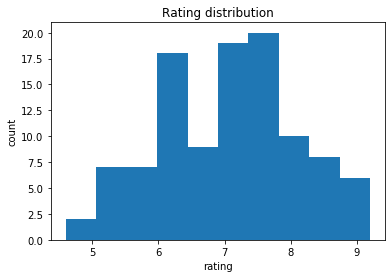

In [215]:
plt.pyplot.hist(details_processed_final["Rating"])

# set x/y labels and plot title
plt.pyplot.xlabel("rating")
plt.pyplot.ylabel("count")
plt.pyplot.title("Rating distribution")

From the histogram above, it is decided that we have our cutoff point of "successful restaurants" to be the borderline between the top 30% and the bottom 70% of the mix.  It is determined that the cutoff point will be 7.6.  

In [216]:
top_percentile = np.percentile(details_processed_final["Rating"], 70) 
# return 70th percentile
print (top_percentile)

7.6


Using the cutoff value, we create a new column named "Successful", restaurants above the cut will be given the value "successful", whereas the others will be named "below cutoff point".  

In [217]:
successful = []
for item in details_processed_final["Rating"]:
    if (item >= top_percentile):
        successful.append('Successful')
    else:
        successful.append('Below Cutoff Point')

details_processed_final = details_processed_final.drop(labels='Rating', axis=1)
details_processed_final['Successful'] = successful

In [231]:
print(details_processed_final.shape)
details_processed_final.head()

(106, 31)


,NumName,Contact,Twitter,Facebook,Instagram,NumCategories,Verified,Webpage,PriceTier,Menu,DeliveryService,TipsCount,PhotosCount,ListedCount,CreatedAt,CardPayments,OutdoorSeating,Breakfast,Brunch,Lunch,Dinner,HappyHour,Dessert,BarSnacks,TastingMenu,Beer,Wine,FullBar,Cocktails,BYO,Successful
0,3,False,True,True,True,2,False,True,0.0,True,True,0.088670,0.181058,0.142122,0.885946,True,False,False,False,True,True,False,False,False,False,False,False,False,False,False,Successful
1,1,True,False,False,False,1,False,True,0.0,False,True,0.029557,0.010446,0.005836,0.641316,True,False,False,False,True,True,False,False,False,False,False,False,False,False,False,Not successful
2,3,True,True,False,False,2,True,True,1.0,True,True,0.256158,0.176880,0.046344,0.400090,True,False,True,True,True,False,False,False,False,False,False,False,False,False,False,Successful
3,4,True,False,False,False,1,True,True,1.0,True,True,0.029557,0.010446,0.001716,0.441234,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,Not successful
4,3,False,False,False,False,1,False,True,0.0,False,True,0.007389,0.004875,0.003776,0.640232,True,False,False,False,True,True,False,False,False,False,False,False,False,False,False,Not successful


Another Folium map is used to visualise the restaurants with rating.  

In [243]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[40.712750, -74.0060152], zoom_start=12)

# add markers to map
for lat, lng, name, rating,successful in zip(details_processed['Latitude'], details_processed['Longitude'], sample_restaurants_detail['Name'], details_processed['Rating'],details_processed_final['Successful']):
    label = '{}, {}'.format(name, rating)
    label = folium.Popup(label, parse_html=True)
    
    if (successful == 'Successful'):
        folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    elif (successful != 'Successful'):
        folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)
    
map_newyork

### Machine Learning: Determine Traits of Successful Restaurants in New York City

"details_processed_final" is splitted into 2, one containing the predictors (X) and the other containing the target (Y).  The target is the rating of the restaurants, with all the other attributes being the predictors for the classification tree.  

In [219]:
X = details_processed_final.iloc[:,0:30]
Y = details_processed_final.iloc[:,30]

A training set and a test set are created with ratio 7:3.  

In [220]:
X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, Y, test_size=0.3, random_state=3)

The classification model is created and fitted with the training set.  

In [246]:
restaurantTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
restaurantTree # it shows the default parameters

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [247]:
restaurantTree.fit(X_trainset,y_trainset)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

The decision tree is created in the form of a diagram for better visualisation.  

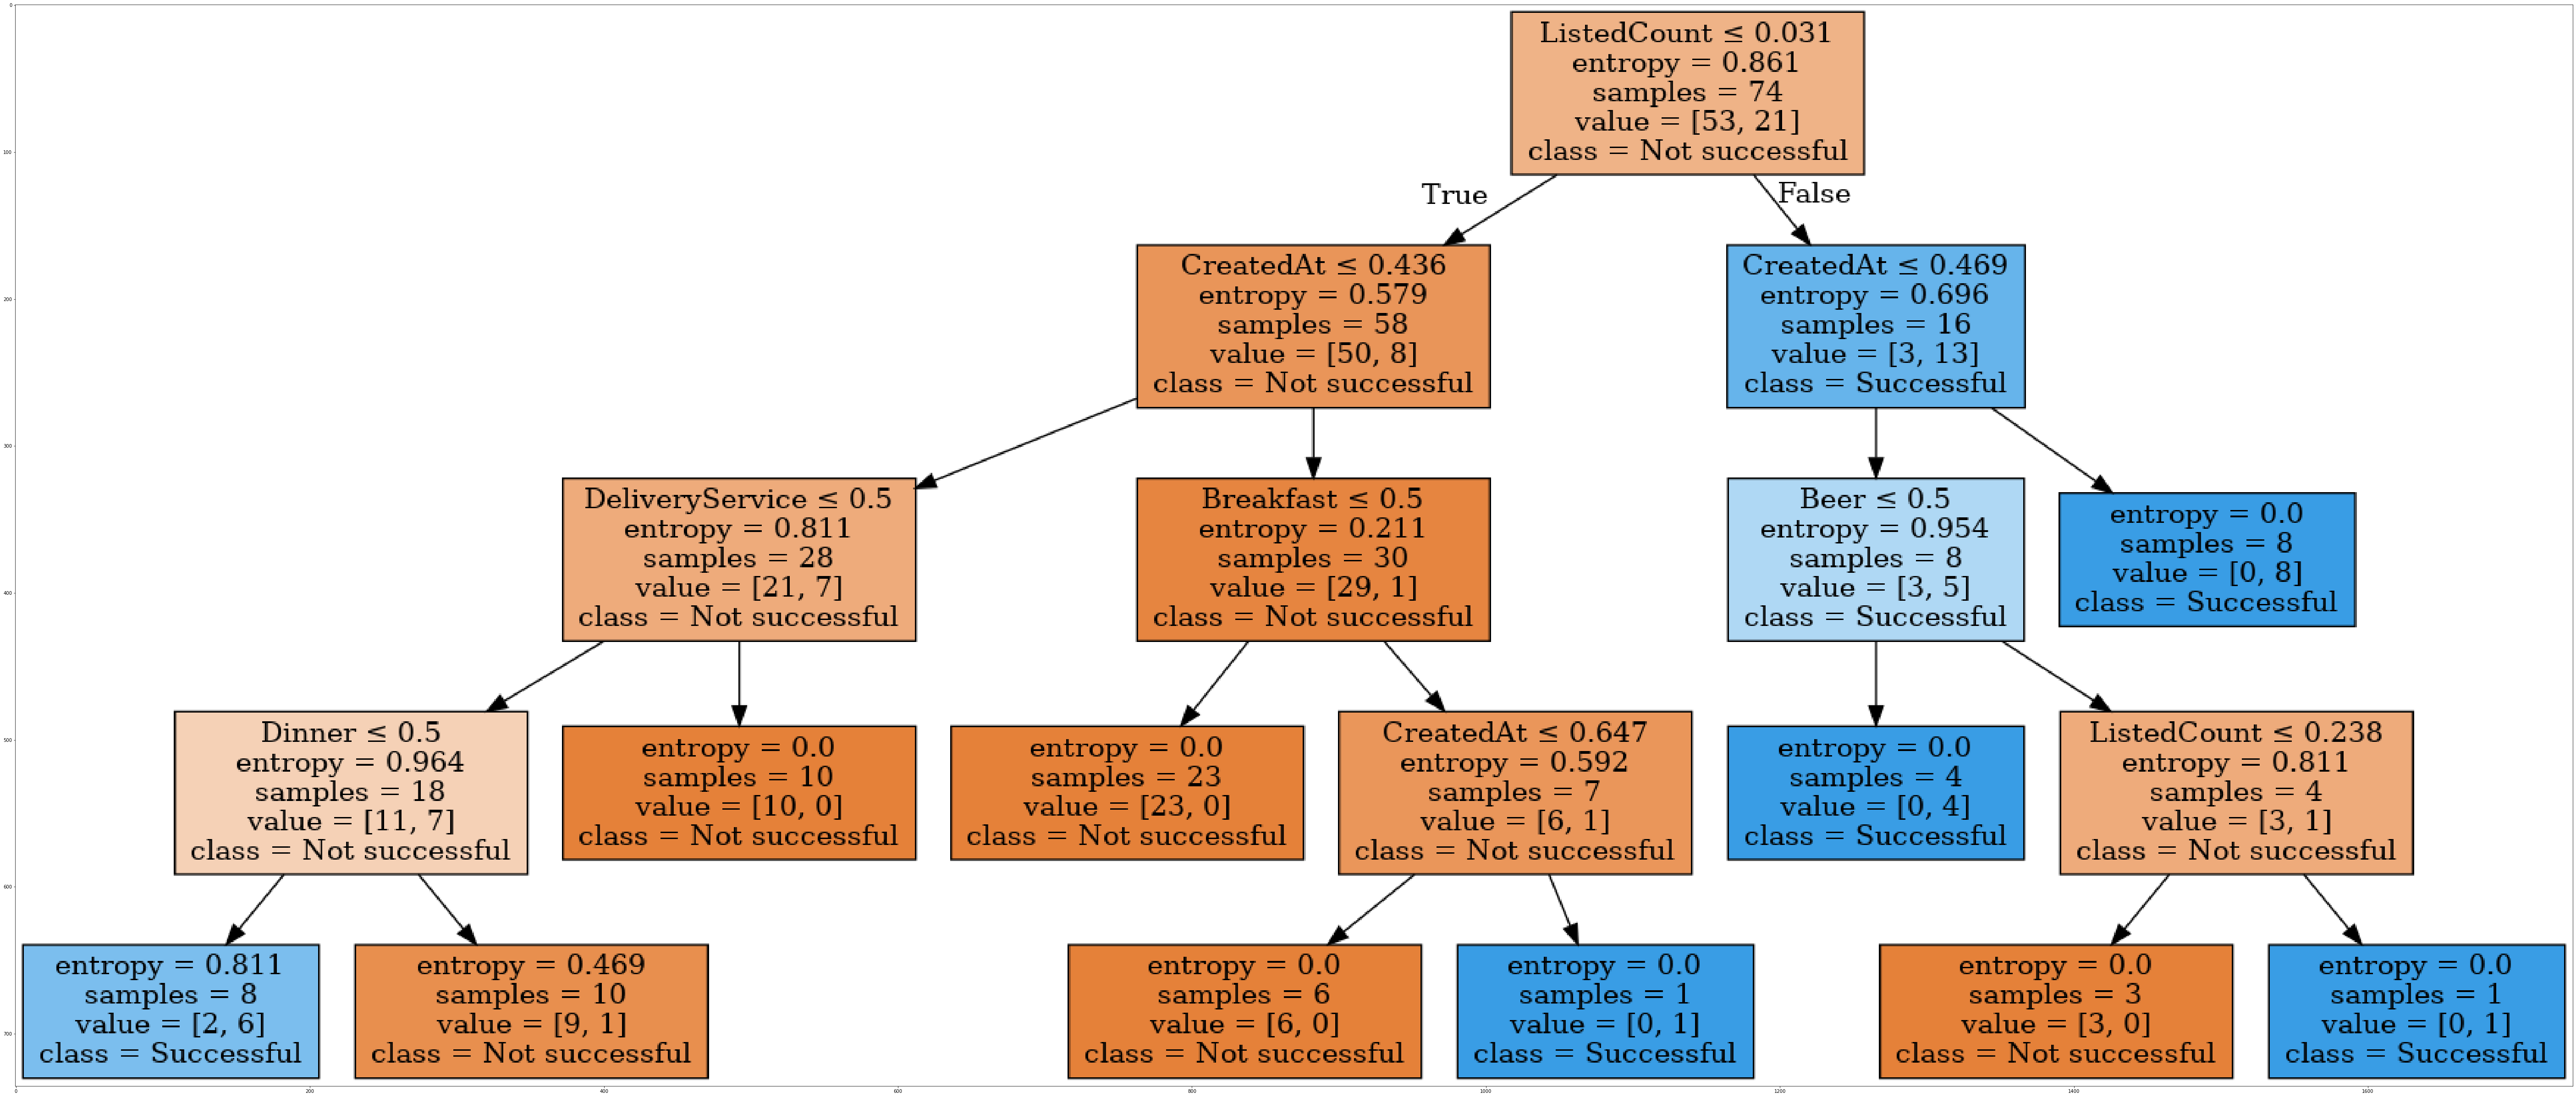

In [227]:
dot_data = StringIO()
filename = "restauranttree.png"
featureNames = details_processed_final.columns[0:30]
targetNames = details_processed_final["Successful"].unique().tolist()
out=tree.export_graphviz(restaurantTree,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_trainset), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

The accuracy of the decision tree is calculated using the metrics.accuracy_score for the test set.  

In [228]:
predTree = restaurantTree.predict(X_testset)

from sklearn import metrics
import matplotlib.pyplot as plt
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_testset, predTree))

DecisionTrees's Accuracy:  0.75


The result of this decision tree is further discussed in the report.  